Se analizaran los datos de Grupo Financiero Inbursa, desde el 7-02-2001 hasta 4-02-2021

In [2]:
import torch, pywt, csv, numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls
import src.utilerias.seniales.dwt.dwt_multinivel as m_dwt
# Llamamos a la función antes de ejecutar el script
logs_dir = 'logs/DWT_NARNN/estandar'
logs_dir_auto_pred = 'logs/DWT_NARNN/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

In [3]:
from src.modelos.auto_regresivo.entrenamientos.entrenamiento import Entrenamiento as entr
from src.modelos.auto_regresivo.NARNN.NARNN import NARNN
criterion = nn.MSELoss()
redes = {"red_A1" : 'models/red_A1.pth',
         "red_D1" : 'models/red_D1.pth',
         "red_D2" : 'models/red_D2.pth',
         "red_D3" : 'models/red_D3.pth',
         "red_D4" : 'models/red_D4.pth',
         "red_D5" : 'models/red_D5.pth'}

Longitud de la entrada: 260


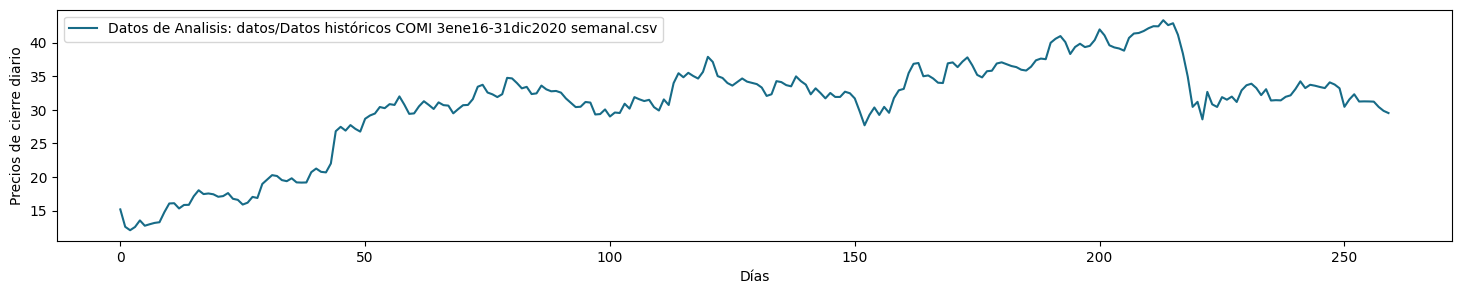

In [4]:
# Abrir el archivo CSV en modo lectura

# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

cierre = rd.leer_archivo(DATOS)
#se convierten todos los valores a flotantes
cierre = cierre.astype(float)

# Crear un gráfico de línea con los valores de x, y
print(f"Longitud de la entrada: {len(cierre)}")
plt.figure(figsize=(18, 3))
plt.plot(range(len(cierre)), cierre, label=f"Datos de Analisis: {DATOS}", color='#176B87')
plt.xlabel('Días')
plt.ylabel('Precios de cierre diario')
plt.legend()
plt.show()

# Eleccion de Mother Wavelet

Se elige las mother wavelets dependiendo de las caracteristicas de la serie de tiempo que se va a analizar. Para series que impliquen cambios no smoothos y repentinos es recomendable usar Haar ya que responde bien a estos cambios repentinos.

Se elige bior3.5 debido a las caracteristicas de las fluctuaciones entre periodos con altas cantidades de inversiones y periodos en los que no.

En general, el mother wavelet debe de ser una funcion de las caracteristicas de la serie original para que esta pueda ser reconstruida o analizada 

Longitud de la entrada de cA: 135


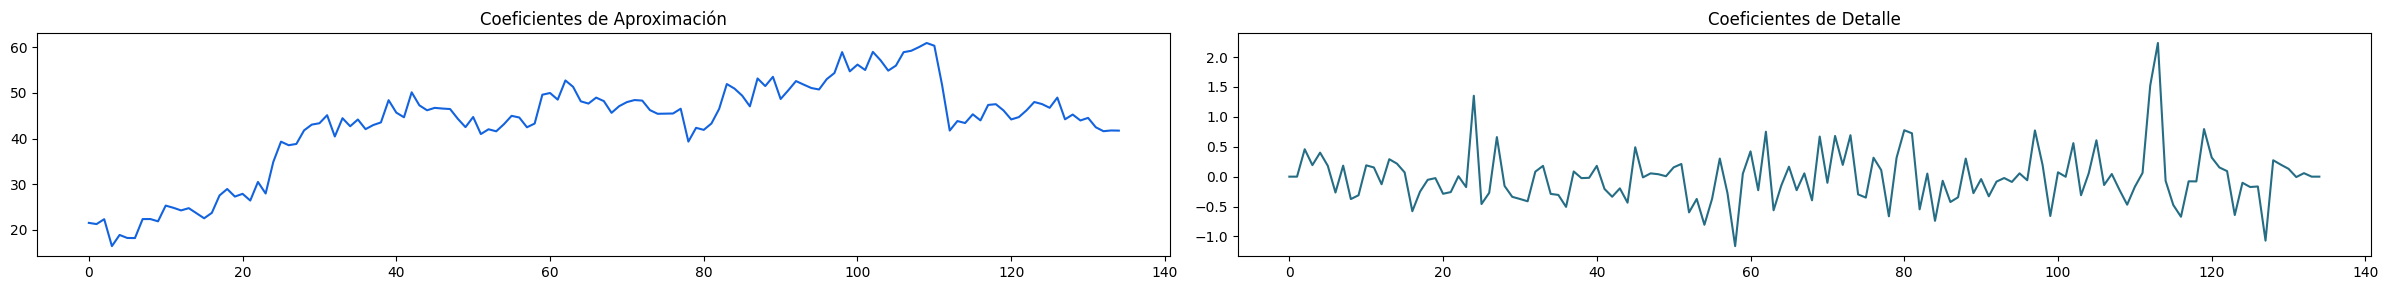

In [5]:
#Se descompone la lista de precios de cierre del intervalo mencionado anteriormente a partir de la dwt con la función bior3.5
# print(pywt.wavelist()) imprime la lista de wavelets de la biblioteca
wavelet = 'bior3.5'
mode = pywt.Modes.constant #antireflect, smooth
wavelet = pywt.Wavelet(wavelet)
(cA, cD) = pywt.dwt(cierre.tolist(), wavelet, mode=mode)
print(f"Longitud de la entrada de cA: {len(cA)}")

plt.figure(figsize=(24, 3))
aprox_coef = True
index = 1

for _ in [cA, cD]:
    plt.subplot(1, 2, index)
    plt.plot(_, color='#1363DF' if aprox_coef else '#256D85')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    index = index + 1

plt.tight_layout()
plt.show()

1. Divide the weekly closing stock prices into a training dataset (70%) and a testing dataset (30%). 
Se realiza la separacion del conjunto de entrenamiento y el de prueba
<img src="/imagenes/DWT-NARNN_step1.png" alt="Descripción de la imagen">

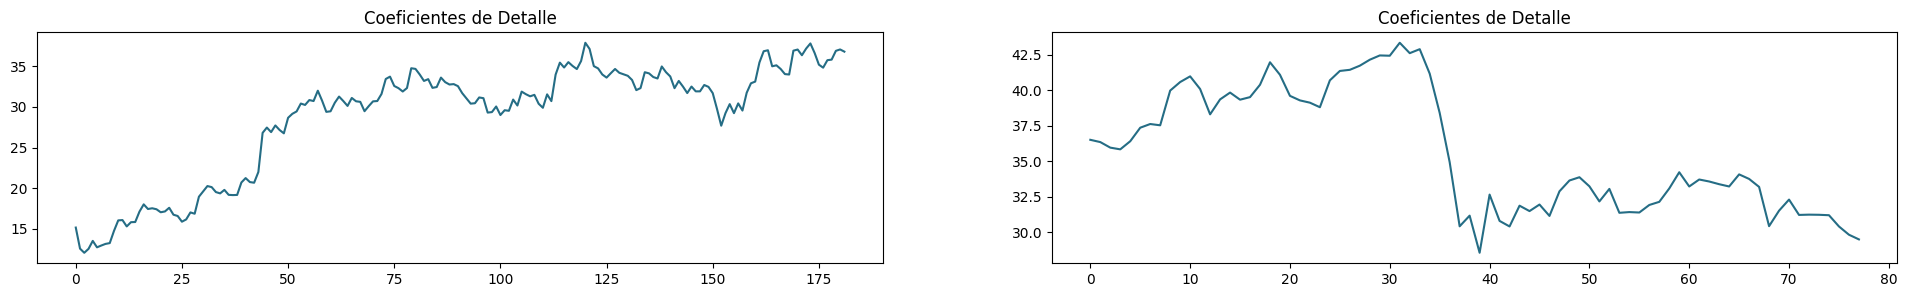

In [6]:
#Se realiza el proceso 5 veces
cierre_e = cierre[:int(len(cierre) * 0.7)]#cierre entrenamiento len 182
cierre_p = cierre[int(len(cierre) * 0.7):]#cierre prueba len 78

plt.figure(figsize=(24, 3))
index = 1

for _ in [cierre_e, cierre_p]:
    plt.subplot(1, 2, index)
    plt.plot(range(len(_)), _, color='#1363DF' if aprox_coef else '#256D85')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    index = index + 1

Decompose the training dataset by the DWT, 
utilizing the biorthogonal 3.5 mother wavelet, into 
approximation coefficients A(t) and detail coefficients D(t), as 
discussed  in  section  2.1.  Set  the  decomposition  level  to  five 
[12] and extract six components D1, D2, D3, D4, D5, and A5.

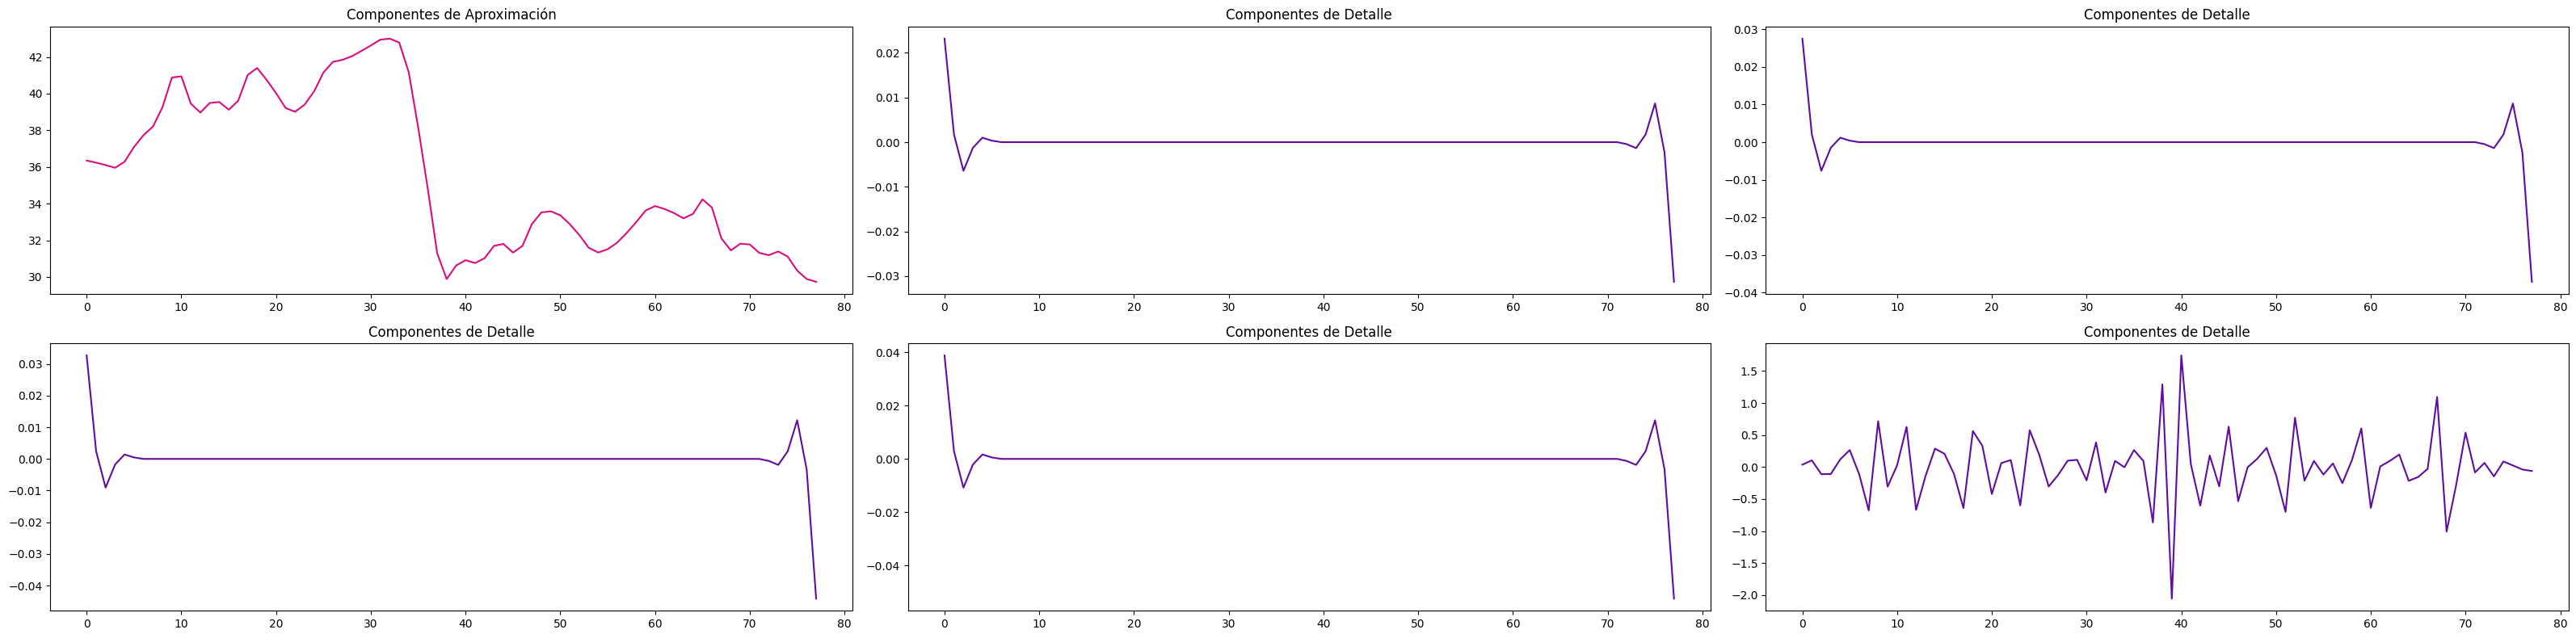

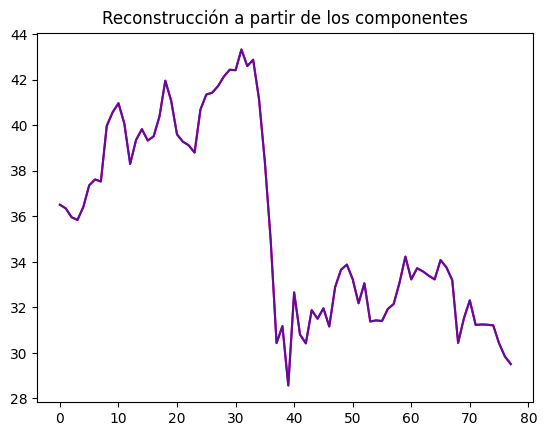

In [7]:
mode = 'constant'
components = m_dwt.multilevel_dwt(cierre, wavelet, 5, mode) #componentes de la serie completa
components_e = m_dwt.multilevel_dwt(cierre_e, wavelet, 5, mode) # componentes de entrenamiento list[np.array[]*] lista de 6 arreglos de forma (182,)
components_p = m_dwt.multilevel_dwt(cierre_p, wavelet, 5, mode) #componentes de prueba list[np.array[]*] lista de 6 arreglos de forma (78,)

plt.figure(figsize=(32, 8))
aprox_coef = True
index = 1

for _ in components_p:
    plt.subplot(2, 3, index)
    plt.plot(range(len(_)), _, color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Componentes de Aproximación' if aprox_coef else 'Componentes de Detalle')
    aprox_coef = False
    index = index + 1

plt.tight_layout()
plt.show()

o_data = 0 #original data
for c in components_p:
    o_data =  o_data + c

plt.plot(o_data, color='#DA0C81')
plt.plot(o_data, color='#610C9F')
plt.title('Reconstrucción a partir de los componentes')
plt.show()

3. Normalize the decomposed components using the Min-Max normalization method.

In [8]:
#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
components_e_n = [utls.normalizar(vect) for vect in components_e] # componentes de entrenamiento normalizados
components_p_n = [utls.normalizar(vect) for vect in components_p] # componentes de prueba normalizados len 78

#Se concatenan los ultimo 8 elementos del conjunto de entrenamiento para predecir el primero del conjunto de prueba
# ahora cada uno de los arreglos dentro de components_p y components_p_n tiene forma (84,)
for i in range(len(components_p_n)):
    components_p[i] = np.concatenate((components_e[i][-8:],components_p[i]))
    components_p_n[i] = np.concatenate((components_e_n[i][-8:],components_p_n[i]))

# Estos 6 arreglos representan la descomposición de la señal original. Se tendrán que armar 6 redes que predigan cada una de estas
# componentes, Las entradas correspondientes a cada una son las 8 semanas anteriores para calcular la novena

4. Build  six  NARNNs,  with  the  topology  shown  in Figure 3, to forecast each decomposed component. The number of feedback delays in the TDL is set to eight, i.e., the preceding  eight  weeks'  closing  prices  are  utilized  to  forecast the ninth-week closing price.

In [9]:
networks = []
s_componentes = ["A5", "D5", "D4", "D3", "D2", "D1"]

for nombre in s_componentes:
    red = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0, nombre="DWT_NARNN_" + nombre)
    red.load_state_dict(torch.load('redes/DWT_NARNN/estandar/red_' + nombre + '.pth'))
    red.eval()
    networks.append(red)

#entradas ya procesadas
entrenamiento_8_1 = [[],[],[],[],[],[]]
prueba_8_1 = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
for e in range(6):
    entrenamiento_8_1[e] = utls.corrimiento_t_1(components_e_n[e],9) # list(tensor[()]*) una lista de 174 tensores con 9 elementos cada uno
    prueba_8_1[e] = utls.corrimiento_t_1(components_p_n[e],9) # list(tensor[()]*) una lista de 78 tensores con 9 elementos cada uno

# esta configuración hace que se prediga a partir de los 8 primeros datos y se haga un corrimiento de 1 hasta predecir con todos los elementos del conjunto
# de entrenamiento y prueba, es decir hasta que predice un elemento mas con el ultimo subarreglo, al final se tendrán 174 y 78 predicciones

5. Divide the training dataset into three parts: 70% for training, 15% for validation, and 15% as test data. Then train the six NARNNs

In [11]:
#Se define el número de epocas
EPOCAS = 5

In [12]:
# Se realiza el entrenamiento de cada una de las redes y se guarda el modelo ya entrenado

# entr_A5 = entr(networks[0],0,writer_dir=logs_dir)
# entr_A5.entrena_lm(entrenamiento_8_1[0],EPOCAS,lr=0.01,λ=0.1,e_predictivo=False)
# torch.save(networks[0].state_dict(), 'redes/DWT_NARNN/red_A1.pth') #Salvamos el estado actual del modelo

# entr_D5 = entr(networks[1],writer_dir=logs_dir)
# entr_D5.entrena_lm(entrenamiento_8_1[1],EPOCAS,lr=0.01,λ=0.1,e_predictivo=False)
# torch.save(networks[1].state_dict(), 'redes/DWT_NARNN/red_D5.pth') 

# entr_D4 = entr(networks[2],2,writer_dir=logs_dir)
# entr_D4.entrena_lm(entrenamiento_8_1[2],EPOCAS,lr=0.01,λ=0.1,e_predictivo=False)
# torch.save(networks[2].state_dict(), 'redes/DWT_NARNN/red_D4.pth')

# entr_D3 = entr(networks[3],3,writer_dir=logs_dir)
# entr_D3.entrena_lm(entrenamiento_8_1[3],EPOCAS,lr=0.01,λ=0.1,e_predictivo=False)
# torch.save(networks[3].state_dict(), 'redes/DWT_NARNN/red_D3.pth') 

# entr_D2 = entr(networks[4],4,writer_dir=logs_dir)
# entr_D2.entrena_lm(entrenamiento_8_1[4],EPOCAS,lr=0.01,λ=0.1,e_predictivo=False)
# torch.save(networks[4].state_dict(), 'redes/DWT_NARNN/red_D2.pth')

# entr_D2 = entr(networks[5],5,writer_dir=logs_dir)
# entr_D2.entrena_lm(entrenamiento_8_1[5],EPOCAS,lr=0.1,λ=0.1,e_predictivo=False)
# torch.save(networks[5].state_dict(), 'redes/DWT_NARNN/red_D1.pth')

# entr_A5.cerrar_escritor()
# entr_D5.cerrar_escritor()
#entr_D4.cerrar_escritor()
#entr_D3.cerrar_escritor()
#entr_D2.cerrar_escritor()
#entr_D1.cerrar_escritor()

# Predicción del conjunto de entrenamiento
usando los datos originales para la recurrencia

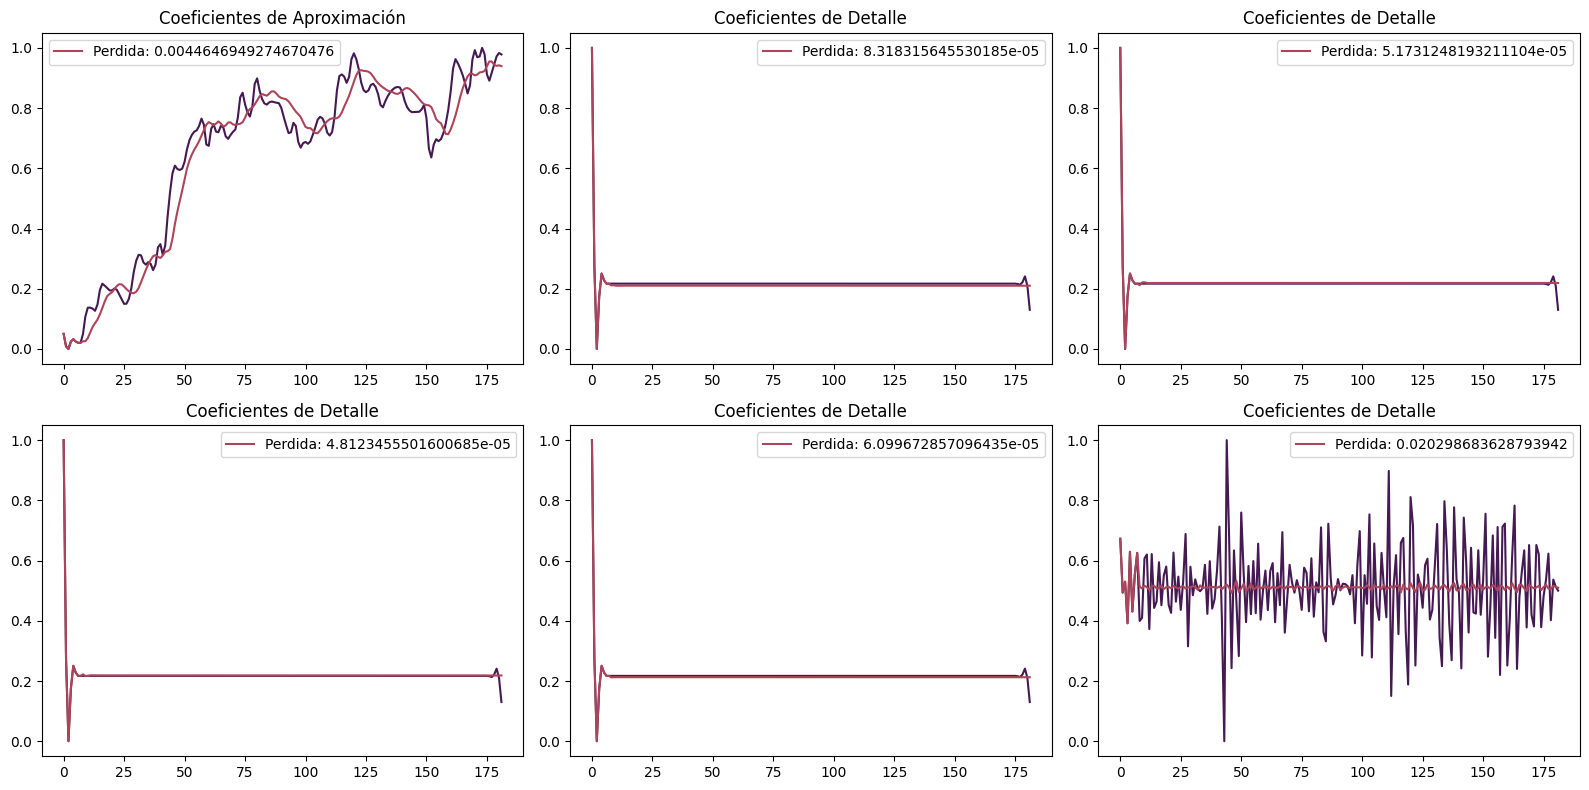

In [13]:
#Se grafica el conjunto de entrenamiento
perdidas = []
predicciones = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in range(len(components_e_n)):
    predicciones.append(utls.genera_prediccion_1(entrenamiento_8_1[_],networks[_],8))
    perdidas.append(criterion(predicciones[_], torch.tensor(components_e_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_e_n[_], color = '#451952') #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(predicciones[_].detach().numpy(), label = f"Perdida: {float(perdidas[_])}", color='#AE445A')#label=f"Datos de Analisis: {DATOS}",
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

# Predicción del conjunto de prueba
usando los datos originales para la recurrencia

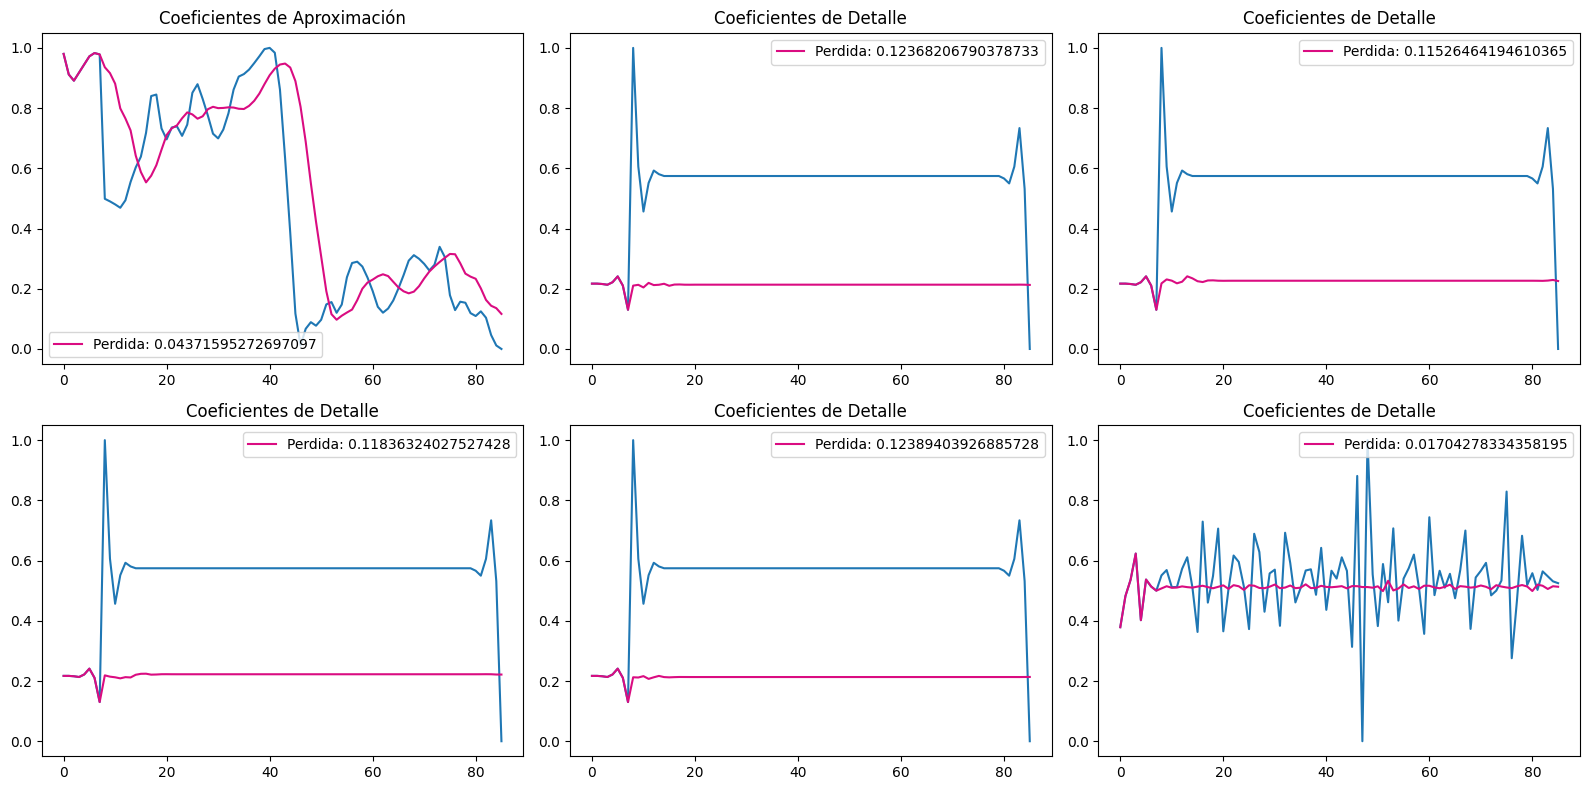

Perdidas: [tensor(0.0437, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1237, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1153, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1184, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1239, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0170, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [14]:
perdidas = []
predicciones = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in range(len(components_p_n)):
    predicciones.append(utls.genera_prediccion_1(prueba_8_1[_],networks[_],8))
    perdidas.append(criterion(predicciones[_], torch.tensor(components_p_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_p_n[_]) #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(predicciones[_].detach().numpy(), label = f"Perdida: {float(perdidas[_])}" ,color='#DA0C81')#label=f"Datos de Analisis: {DATOS}",
    
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas: " + str(perdidas))

#Se grafica el conjunto de pruebas
# plt.plot(range(len(prueba[0])), prueba[0])
# plt.plot(range(len(prueba[0])), utls.genera_prediccion_1(prueba_8_1[0],red_A1,8).detach().numpy())
# plt.show(

#plt.plot(range(108), entrenamiento[0][:-8])
#plt.plot(range(108), [utls.desnormalizar(vect) for vect in utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]])
# Mostrar el gráfico
#plt.show()
#investigar bien la dwt y predecir la red con los corrimientos de 1, usando los datos que predice o solo los datos que le doy
#Lo que hace es generar una prediccion cada noveno día, con los datos que ya se le dan del entrenamiento, es preciso ajustar los parametros hasta que ambas series
#sean iguales
#print(prueba[0])

# Reconstrucción del conjunto de prueba

In [15]:
# Se eliminan los 8 ultimos datos del conjunto de entrenamiento
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][8:]

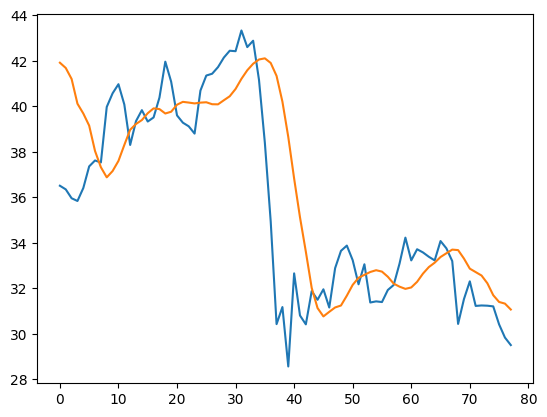

In [16]:
predicciones_d = []
i=0
for vect in predicciones:
    predicciones_d.append(utls.desnormalizar(vect.detach().numpy(),np.max(components_p[i]),np.min(components_p[i])))
    i=i+1

(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d

rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec
rec = torch.tensor(A5_rec) + torch.tensor(D5_rec) + torch.tensor(D4_rec) + torch.tensor(D3_rec) + torch.tensor(D2_rec) + torch.tensor(D1_rec)
plt.plot(cierre_p) #Señal original
plt.plot(rec.detach().numpy()) #Señal predicha
plt.show()

# Evaluación de desempeño

In [17]:
import pandas as pd
r_c_prueba_txt = 'Reconstrucción de c_prueba'
r_A5_txt = 'Reconstrucción de A5'
r_D5_txt = 'Reconstrucción de D5'
r_D4_txt = 'Reconstrucción de D4'
r_D3_txt = 'Reconstrucción de D3'
r_D2_txt = 'Reconstrucción de D2'
r_D1_txt = 'Reconstrucción de D1'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(cierre_p,rec.detach().numpy()),
    r_A5_txt: utls.rmse(components_p[0][8:],rec.detach().numpy()),#le quitamos las primeras 8 que le habiamos agregado
    r_D5_txt: utls.rmse(components_p[1][8:],rec.detach().numpy()),
    r_D4_txt: utls.rmse(components_p[2][8:],rec.detach().numpy()),
    r_D3_txt: utls.rmse(components_p[3][8:],rec.detach().numpy()),
    r_D2_txt: utls.rmse(components_p[4][8:],rec.detach().numpy()),
    r_D1_txt: utls.rmse(components_p[5][8:],rec.detach().numpy())
}
mape = {
    r_c_prueba_txt: utls.mape(cierre_p,rec.detach().numpy()),
    r_A5_txt: utls.mape(components_p[0][8:],rec.detach().numpy()),
    r_D5_txt: utls.mape(components_p[1][8:],rec.detach().numpy()),
    r_D4_txt: utls.mape(components_p[2][8:],rec.detach().numpy()),
    r_D3_txt: utls.mape(components_p[3][8:],rec.detach().numpy()),
    r_D2_txt: utls.mape(components_p[4][8:],rec.detach().numpy()),
    r_D1_txt: utls.mape(components_p[5][8:],rec.detach().numpy())
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(cierre_p,rec.detach().numpy()),
    r_A5_txt: utls.directional_symmetry(components_p[0][8:],rec.detach().numpy()),
    r_D5_txt: utls.directional_symmetry(components_p[1][8:],rec.detach().numpy()),
    r_D4_txt: utls.directional_symmetry(components_p[2][8:],rec.detach().numpy()),
    r_D3_txt: utls.directional_symmetry(components_p[3][8:],rec.detach().numpy()),
    r_D2_txt: utls.directional_symmetry(components_p[4][8:],rec.detach().numpy()),
    r_D1_txt: utls.directional_symmetry(components_p[5][8:],rec.detach().numpy())
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
# df_errores = pd.DataFrame.from_dict(errores, orient='index', columns=['Error de Predicción'])
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                               RMSE          MAPE       DS
Reconstrucción de c_prueba   2.9046  5.698900e+00  48.7179
Reconstrucción de A5         2.8514  5.607200e+00  46.1538
Reconstrucción de D5        36.5505  4.949296e+18  48.7179
Reconstrucción de D4        36.5505  7.282160e+18  51.2821
Reconstrucción de D3        36.5505  5.580200e+18  56.4103
Reconstrucción de D2        36.5505  2.936975e+18  51.2821
Reconstrucción de D1        36.5543  5.987269e+04  53.8462


# Generamos el entrenamiento predictivo

In [18]:
# networks[0].load_state_dict(torch.load('redes/DWT_NARNN/auto_predictiva/red_A5_datos_originales_pred.pth'))
# networks[0].eval()

# networks[1].load_state_dict(torch.load('redes/DWT_NARNN/auto_predictiva/red_D5_datos_originales_pred.pth'))
# networks[1].eval()

# networks[2].load_state_dict(torch.load('redes/DWT_NARNN/auto_predictiva/red_D4_datos_originales_pred.pth'))
# networks[2].eval()

# networks[3].load_state_dict(torch.load('redes/DWT_NARNN/auto_predictiva/red_D3_datos_originales_pred.pth'))
# networks[3].eval()

# networks[4].load_state_dict(torch.load('redes/DWT_NARNN/auto_predictiva/red_D2_datos_originales_pred.pth'))
# networks[4].eval()

# networks[5].load_state_dict(torch.load('redes/DWT_NARNN/auto_predictiva/red_D1_datos_originales_pred.pth'))
# networks[5].eval()

for i in range(6):
    model_path = f'redes/DWT_NARNN/auto_predictiva/red_{["A5", "D5", "D4", "D3", "D2", "D1"][i]}_datos_originales_pred.pth'
    networks[i].load_state_dict(torch.load(model_path))
    networks[i].eval()


In [19]:
# referencia: entr.entrena_LM_pred(networks[0],0,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=8,decay_factor=5) #EPOCAS

entr_A5 = entr(networks[0],0, logs_dir_auto_pred)
entr_A5.entrena_lm(entrenamiento_8_1[0],EPOCAS,lr=0.5,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
# torch.save(networks[0].state_dict(), 'redes/DWT_NARNN/red_A5_pred') #Salvamos el estado actual del modelo

entr_D5 = entr(networks[1],1, logs_dir_auto_pred)
entr_D5.entrena_lm(entrenamiento_8_1[1],EPOCAS,lr=0.5,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
# torch.save(networks[1].state_dict(), 'redes/DWT_NARNN/red_D5_pred')

# entr_D4 = entr(networks[2],2,logs_dir +'/auto_predictiva')
# entr_D4.entrena_lm(entrenamiento_8_1[2],EPOCAS,lr=0.5,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
# torch.save(networks[2].state_dict(), 'redes/DWT_NARNN/red_D4_pred')

# entr_D3 = entr(networks[3],3,logs_dir +'/auto_predictiva')
# entr_D3.entrena_lm(entrenamiento_8_1[3],15,lr=0.5,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
# torch.save(networks[3].state_dict(), 'redes/DWT_NARNN/red_D3_pred')

# entr_D2 = entr(networks[4],4,logs_dir +'/auto_predictiva')
# entr_D2.entrena_lm(entrenamiento_8_1[4],15,lr=0.5,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
# torch.save(networks[4].state_dict(), 'redes/DWT_NARNN/red_D2_pred')

# entr_D1 = entr(networks[5],5,logs_dir +'/auto_predictiva')
# entr_D1.entrena_lm(entrenamiento_8_1[5],15,lr=0.5,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
# torch.save(networks[5].state_dict(), 'redes/DWT_NARNN/red_D1_pred')

#entr_A5.cerrar_escritor()
#entr_D5.cerrar_escritor()
#entr_D4.cerrar_escritor()
#entr_D3.cerrar_escritor()
#entr_D2.cerrar_escritor()
#entr_D1.cerrar_escritor()

---INICIO DE ENTRENAMIENTO: entrena_LM---
---Inicio de epoca: 0--
-----> Predicción pre entreno: tensor([0.2409], grad_fn=<ViewBackward0>) 
-----> Predicción pre entreno: tensor([0.2579], grad_fn=<ViewBackward0>) 
-----> Predicción pre entreno: tensor([0.2903], grad_fn=<ViewBackward0>) 
-----> Predicción pre entreno: tensor([0.3204], grad_fn=<ViewBackward0>) 
-----> Predicción pre entreno: tensor([0.3607], grad_fn=<ViewBackward0>) 
-----> Predicción pre entreno: tensor([0.4152], grad_fn=<ViewBackward0>) 
-----> Predicción pre entreno: tensor([0.4684], grad_fn=<ViewBackward0>) 
-----> Predicción pre entreno: tensor([0.4937], grad_fn=<ViewBackward0>) 
>>Paso...<<
>>Fin de paso<<
>>Se calcula perdida despues del paso...
entrada: tensor([0.0503, 0.0086, 0.0000, 0.0245, 0.0327, 0.0246, 0.0205, 0.0203])
----->Salida de la red: tensor([0.1353], grad_fn=<ViewBackward0>)
----->Salida esperada: tensor([0.0494])
entrada: tensor([0.0086, 0.0000, 0.0245, 0.0327, 0.0246, 0.0205, 0.0203, 0.2409],
   

# Predicción del conjunto de prueba
usando los datos predictivos para la recurrencia

6. Predict  the  future  price  for  each  point  in  the  testing data set as follows:
a) Decompose its preceding price data as described in step 2.  
b) Normalize the decomposed features using Eq. (3). 
c) Predict one step for each component. (El contenido se guarda en el arreglo 'predicciones')
d) De-normalize and aggregate the predicted values. 
e) Repeat steps a, b and c until all the testing dataset 
points are forecasted.

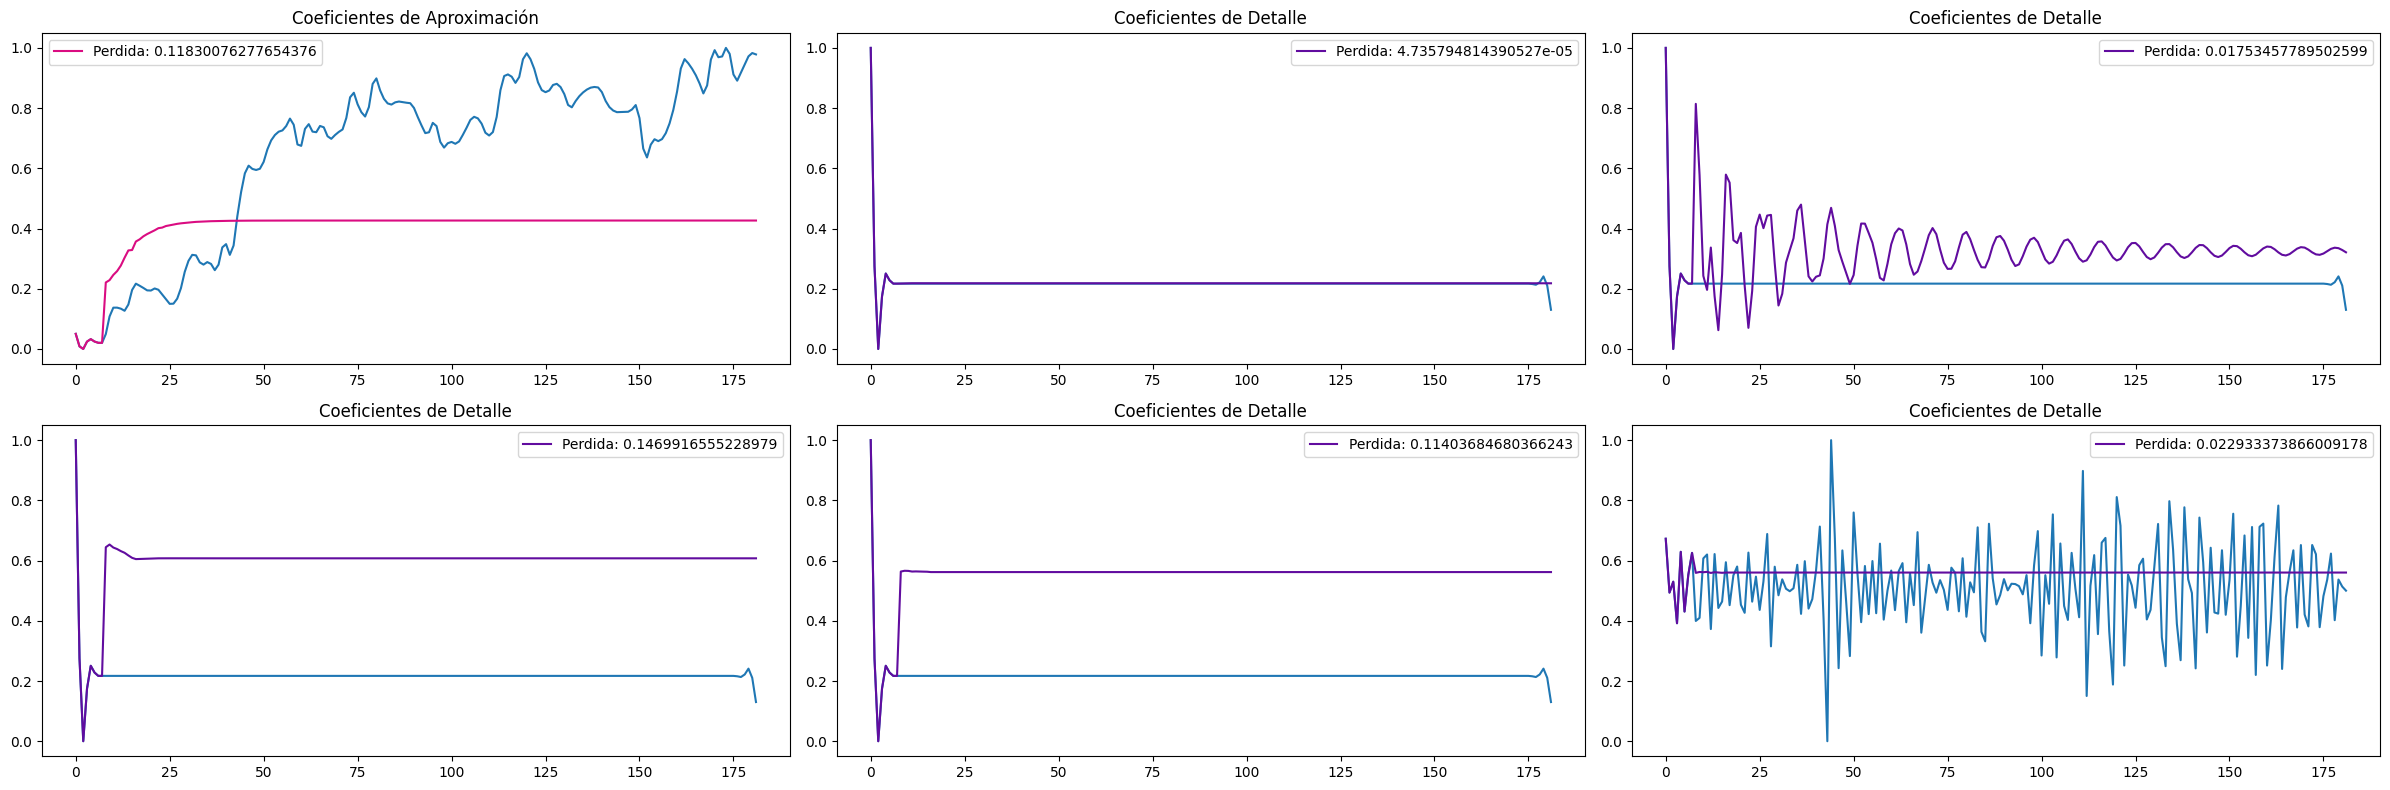

Perdidas predictivas: [tensor(0.1183, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(4.7358e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0175, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1470, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1140, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0229, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [20]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []

for _ in range(len(components_e_n)):
    predicciones.append(utls.genera_prediccion_predictiva(entrenamiento_8_1[_][0][:8],8,len(entrenamiento_8_1[_]),networks[_]))
    perdidas_predictivas.append(criterion(predicciones[_], torch.tensor(components_e_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(range(len(components_e_n[_])), components_e_n[_])
    plt.plot(range(len(components_e_n[_])), predicciones[_].detach().numpy(),  label = f"Perdida: {float(perdidas_predictivas[_])}", color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

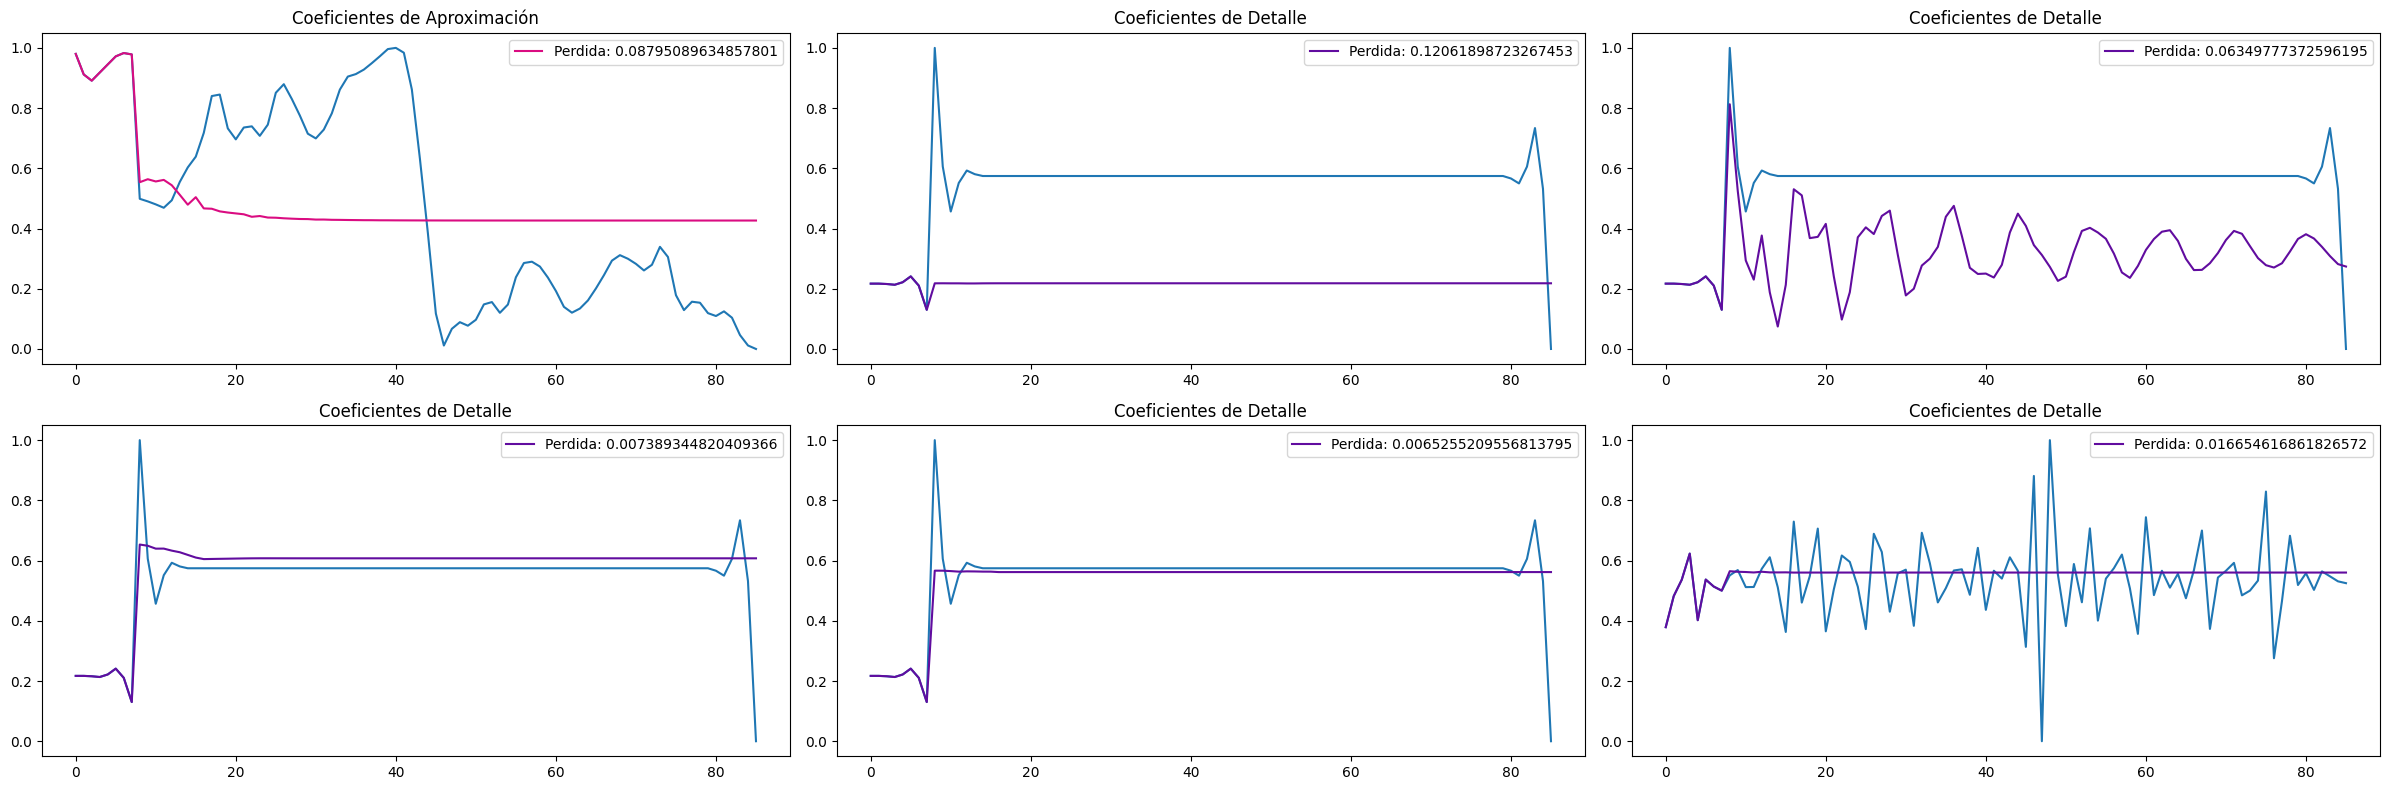

Perdidas predictivas: [tensor(0.0880, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.1206, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0635, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0074, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0065, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0167, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [19]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []

for _ in range(len(components_p_n)):
    predicciones.append(utls.genera_prediccion_predictiva(prueba_8_1[_][0][:8],8,len(prueba_8_1[_]),networks[_]))
    perdidas_predictivas.append(criterion(predicciones[_], torch.tensor(components_p_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_p_n[_])
    plt.plot(predicciones[_].detach().numpy(),  label = f"Perdida: {float(perdidas_predictivas[_])}", color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

# Reconstruimos la señal original usando el conjunto de prueba

In [20]:
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][8:]

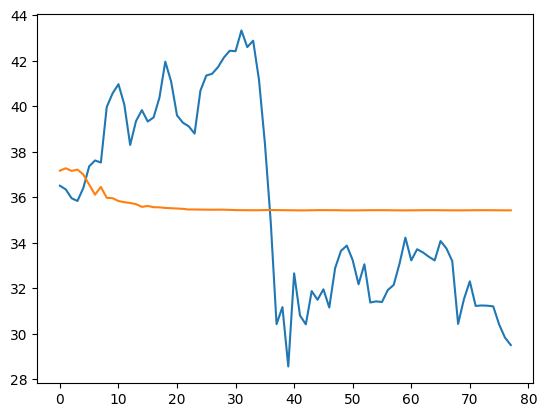

In [21]:
predicciones_d = []
i=0
for vect in predicciones:
    predicciones_d.append(utls.desnormalizar(vect.detach().numpy(),np.max(components_p[i]),np.min(components_p[i])))
    i=i+1

(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d

rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec
rec = torch.tensor(A5_rec) + torch.tensor(D5_rec) + torch.tensor(D4_rec) + torch.tensor(D3_rec) + torch.tensor(D2_rec) + torch.tensor(D1_rec)

plt.plot(cierre_p) #Señal original
plt.plot(rec) #Señal predicha
plt.show()


# Evaluación de desempeño

In [22]:
import pandas as pd
r_c_prueba_txt = 'Reconstrucción de c_prueba'
r_A5_txt = 'Reconstrucción de A5'
r_D5_txt = 'Reconstrucción de D5'
r_D4_txt = 'Reconstrucción de D4'
r_D3_txt = 'Reconstrucción de D3'
r_D2_txt = 'Reconstrucción de D2'
r_D1_txt = 'Reconstrucción de D1'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(cierre_p,rec.detach().numpy()),
    r_A5_txt: utls.rmse(components_p[0][8:],rec.detach().numpy()),#le quitamos las primeras 8 que le habiamos agregado
    r_D5_txt: utls.rmse(components_p[1][8:],rec.detach().numpy()),
    r_D4_txt: utls.rmse(components_p[2][8:],rec.detach().numpy()),
    r_D3_txt: utls.rmse(components_p[3][8:],rec.detach().numpy()),
    r_D2_txt: utls.rmse(components_p[4][8:],rec.detach().numpy()),
    r_D1_txt: utls.rmse(components_p[5][8:],rec.detach().numpy())
}
mape = {
    r_c_prueba_txt: utls.mape(cierre_p,rec.detach().numpy()),
    r_A5_txt: utls.mape(components_p[0][8:],rec.detach().numpy()),
    r_D5_txt: utls.mape(components_p[1][8:],rec.detach().numpy()),
    r_D4_txt: utls.mape(components_p[2][8:],rec.detach().numpy()),
    r_D3_txt: utls.mape(components_p[3][8:],rec.detach().numpy()),
    r_D2_txt: utls.mape(components_p[4][8:],rec.detach().numpy()),
    r_D1_txt: utls.mape(components_p[5][8:],rec.detach().numpy())
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(cierre_p,rec.detach().numpy()),
    r_A5_txt: utls.directional_symmetry(components_p[0][8:],rec.detach().numpy()),
    r_D5_txt: utls.directional_symmetry(components_p[1][8:],rec.detach().numpy()),
    r_D4_txt: utls.directional_symmetry(components_p[2][8:],rec.detach().numpy()),
    r_D3_txt: utls.directional_symmetry(components_p[3][8:],rec.detach().numpy()),
    r_D2_txt: utls.directional_symmetry(components_p[4][8:],rec.detach().numpy()),
    r_D1_txt: utls.directional_symmetry(components_p[5][8:],rec.detach().numpy())
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
# df_errores = pd.DataFrame.from_dict(errores, orient='index', columns=['Error de Predicción'])
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                               RMSE          MAPE       DS
Reconstrucción de c_prueba   4.1686  1.050430e+01  42.3077
Reconstrucción de A5         4.1295  1.046430e+01  37.1795
Reconstrucción de D5        35.6292  4.689430e+18  55.1282
Reconstrucción de D4        35.6292  6.882142e+18  44.8718
Reconstrucción de D3        35.6292  5.527739e+18  52.5641
Reconstrucción de D2        35.6292  2.890112e+18  55.1282
Reconstrucción de D1        35.6329  5.900386e+04  50.0000
